# Execution Interval Method

In [1]:
import json
import os
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from collections import defaultdict
from libraries.utils import *
from libraries.exeint import exeInt




## Load Data

In [2]:
############ configuration ################
############################################

CODE = 'mamba2'       ### application (code)    theft_protection, mamba2, lora_ducy
BEHAVIOUR_FAULTY = 'faulty_data'            ### normal, faulty_data
BEHAVIOUR_NORMAL = 'normal'            ### normal, faulty_data
THREAD = 'single'           ### single, multi
VER = 3                     ### format of data collection

base_dir = '../trace_data' ### can be replaced with 'csv', 'exe_plot', 'histogram'
normalbase_path = base_dir+f'/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_NORMAL}'
faultybase_path = base_dir+f'/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_FAULTY}'

print(normalbase_path)
print(faultybase_path)

../trace_data/mamba2/single_thread/version_3/normal
../trace_data/mamba2/single_thread/version_3/faulty_data


In [3]:

train_base_path = os.path.join(normalbase_path, 'train_data')
train_data_path = [os.path.join(train_base_path, x) for x in os.listdir(train_base_path)]
train_varlist_path = os.listdir(normalbase_path)
train_varlist_path = [os.path.join(normalbase_path, x) for x in train_varlist_path if 'varlist' in x]

######### get paths #######################
paths_log, paths_traces, varlist_path, paths_label = get_paths(faultybase_path)

### remove.Ds_store from all lists
train_data_path = [x for x in train_data_path if '.DS_Store' not in x]
train_varlist_path = [x for x in train_varlist_path if '.DS_Store' not in x]
paths_log = [x for x in paths_log if '.DS_Store' not in x]
paths_traces = [x for x in paths_traces if '.DS_Store' not in x]
varlist_path = [x for x in varlist_path if '.DS_Store' not in x]
paths_label = [x for x in paths_label if '.DS_Store' not in x]

paths_log.sort()
paths_traces.sort()
varlist_path.sort()
paths_label.sort()

# print(paths_log)
# print(paths_traces)
# print(varlist_path)
# print(paths_label)

test_data_path = paths_traces
test_label_path = paths_label

print(train_data_path)
print(test_data_path)
print(test_label_path)


['../trace_data/mamba2/single_thread/version_3/normal/train_data/interval_8260_11000.json', '../trace_data/mamba2/single_thread/version_3/normal/train_data/interval_0_6200.json', '../trace_data/mamba2/single_thread/version_3/normal/train_data/interval_6500_9910.json', '../trace_data/mamba2/single_thread/version_3/normal/train_data/interval_0_8260.json', '../trace_data/mamba2/single_thread/version_3/normal/train_data/trace_trial3']
['../trace_data/mamba2/single_thread/version_3/faulty_data/trace_trial2', '../trace_data/mamba2/single_thread/version_3/faulty_data/trace_trial3', '../trace_data/mamba2/single_thread/version_3/faulty_data/trace_trial4']
['../trace_data/mamba2/single_thread/version_3/faulty_data/labels/trace_trial2_labels.json', '../trace_data/mamba2/single_thread/version_3/faulty_data/labels/trace_trial3_labels.json', '../trace_data/mamba2/single_thread/version_3/faulty_data/labels/trace_trial4_labels.json']


In [4]:
varlist_path

['../trace_data/mamba2/single_thread/version_3/faulty_data/varlist_trial2.json',
 '../trace_data/mamba2/single_thread/version_3/faulty_data/varlist_trial3.json',
 '../trace_data/mamba2/single_thread/version_3/faulty_data/varlist_trial4.json']

In [5]:
############# check varlist is consistent ############
############# only for version 3 ######################

if VER == 3:
    check_con, _ = is_consistent([train_varlist_path[0]]+ varlist_path) ### compare with train varlist

    if check_con != False:
        to_number = read_json(varlist_path[0])
        from_number = mapint2var(to_number)
    else:
        ### load normal varlist
        print('loading normal varlist')
        to_number = read_json(train_varlist_path[0])
        from_number = mapint2var(to_number)



varlist 1 is consistent with varlist 0
varlist 2 is consistent with varlist 0
varlist 3 is consistent with varlist 0


In [6]:
# #### key finder ####
# from_number[44]

In [7]:
############ Get variable list ######################
sorted_keys = list(from_number.keys())
sorted_keys.sort()
var_list = [from_number[key] for key in sorted_keys]   ### get the variable list
# print(var_list)

## Confidence Interval

__Confidence Interval:__

A confidence interval is a range around the mean that is likely to contain the true population mean. The formula for a confidence interval is mean ± margin of error mean±margin of error, where the margin of error depends on the desired confidence level and the standard error.

_Example:_

1. Choose a confidence level (e.g., 95%).
2. Calculate the standard error: standard deviation/ sqr_root(number of observations)
3. Calculate the margin of error: critical value × standard error
4. Determine the confidence interval: mean ± margin of error


In [8]:
### initialize exeinz
ei = exeInt()

### Data Processing

In [9]:
### get execution intervals for all variables

exe_list, filewise_exe_list = ei.get_exeint(train_data_path)

../trace_data/mamba2/single_thread/version_3/normal/train_data/interval_8260_11000.json
../trace_data/mamba2/single_thread/version_3/normal/train_data/interval_8260_11000.json
dict_keys([56, 57, 67, 23, 24, 49, 50, 31, 53, 54, 55, 58, 59, 20, 21, 22, 60, 61, 62, 63, 64, 65, 66, 70, 68, 69, 51, 26, 71, 72, 73, 27, 52, 28, 29])
56 449171 449951
56 449951 449992
56 449992 450807
56 450807 451587
56 451587 452366
56 452366 453145
56 453145 453187
56 453187 454002
56 454002 454781
56 454781 455561
56 455561 456340
56 456340 456534
56 456534 457350
56 457350 458129
56 458129 458909
56 458909 459688
56 459688 459730
56 459730 460545
56 460545 461324
56 461324 462104
56 462104 462883
56 462883 462928
56 462928 463743
56 463743 464523
56 464523 465302
56 465302 466081
56 466081 466124
56 466124 466938
56 466938 467717
56 467717 468496
56 468496 469276
56 469276 469321
56 469321 470137
56 470137 470916
56 470916 471695
56 471695 472475
56 472475 472518
56 472518 473332
56 473332 474112
56 474112

In [10]:
for k in list(exe_list.keys()):
    print(k, len(exe_list[k]))

56 2675
57 4286
67 530
23 2141
24 2141
49 7508
50 1606
31 534
53 533
54 533
55 533
58 532
59 532
20 532
21 532
22 532
60 532
61 1606
62 532
63 532
64 531
65 531
66 531
70 140
68 49
69 49
51 51
26 51
71 48
72 48
73 109
27 104
52 157
28 29
29 29
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
10 3
11 3
12 3
13 3
14 3
15 3
16 3
17 3
18 3
19 3
25 3
30 3
32 3
33 3
34 3
35 3
36 3
37 3
38 3
39 3
40 3
41 3
42 3
43 3
44 3
45 3
46 3
47 3
48 3
74 3


In [11]:
################## methods to detect outliers based on execution intervals ####################

############ calculate dynamic thresholds ############
thresholds = ei.get_dynamicthresh(exe_list)

############ train lof model ################
lof_models = ei.train_lof(exe_list)

######### save thresholds and lof models ############
### visualize the thresholds for varlist
thresholds_var = {}
for key in thresholds.keys():
    print('key:', key)
    thresholds_var[from_number[key]] = thresholds[key]

assert len(thresholds_var) == len(thresholds)
thresholds_var
save_json(thresholds_var, os.path.join(faultybase_path, 'thresholds.json'))

56
value: 0.8 prob: 0.8
value: 0.0 prob: 0.1685981308411215
value: 0.1 prob: 0.010093457943925233
value: 0.2 prob: 0.020934579439252338
value: 0.9 prob: 0.00037383177570093456
57
value: 0.8 prob: 0.4857676154923005
value: 0.0 prob: 0.500933271115259
value: 1.0 prob: 0.013065795613625758
value: 0.9 prob: 0.0002333177788147457
67
value: 3.4 prob: 0.10754716981132076
value: 3.2 prob: 0.8924528301886793
23
value: 0.9 prob: 0.20737972909855207
value: 0.8 prob: 0.765063054647361
value: 1.1 prob: 0.0014012143858010276
value: 1.0 prob: 0.026156001868285848
24
value: 0.9 prob: 0.20784680056048577
value: 0.8 prob: 0.7645959831854273
value: 1.1 prob: 0.0014012143858010276
value: 1.0 prob: 0.026156001868285848
49
value: 0.0 prob: 0.6435801811401172
value: 0.8 prob: 0.28516249334043686
value: 0.1 prob: 0.06366542354821524
value: 0.2 prob: 0.007458710708577517
value: 0.9 prob: 0.00013319126265316994
50
value: 0.0 prob: 0.6674968866749689
value: 3.2 prob: 0.2970112079701121
value: 3.3 prob: 0.0354919

In [12]:
from_number

{11: '0-0-0-CONNECTION_CO2',
 61: '0-0-0-var',
 38: '0-0-0-BMP',
 13: '0-0-0-CONNECTION_O2',
 64: '0-0-measure_am1-0',
 43: '0-0-0-THRESHOLD_LIMITS',
 28: '0-0-0-msg_interval',
 3: '0-0-0-O2_ADRR',
 6: '0-0-0-AM2301_1_ADRR',
 58: '0-0-measure_scd30-0',
 67: '0-0-measure_am4-0',
 71: '0-0-cb_lora-board_id',
 68: '0-0-cb_30-cb_30_done',
 26: '0-0-0-cb_30_done',
 33: '0-0-0-SPI_BUS',
 60: '0-0-measure_co-0',
 23: '0-0-0-am_temp',
 46: '0-0-0-FUNC_VAR',
 12: '0-0-0-CONNECTION_CO',
 48: '0-0-0-timer1',
 15: '0-0-0-CONNECTION_A1',
 16: '0-0-0-CONNECTION_A2',
 17: '0-0-0-CONNECTION_A3',
 18: '0-0-0-CONNECTION_A4',
 47: '0-0-0-timer0',
 7: '0-0-0-AM2301_2_ADRR',
 37: '0-0-0-MCP_O2',
 49: '0-0-0-SENSOR_DATA',
 5: '0-0-0-SCD30_ADRR',
 34: '0-0-0-lora',
 25: '0-0-0-que',
 65: '0-0-measure_am2-0',
 69: '0-0-add_to_que-que',
 73: '0-0-cb_retrans-cb_retrans_done',
 57: '0-0-0-func_call',
 55: '0-0-0-LIMITS_BROKEN',
 72: '0-0-cb_lora-timestamp',
 44: '0-0-0-CONNECTION_VAR',
 24: '0-0-0-am_hum',
 41: 

In [13]:
thresholds_var

{'0-0-0-j': [0.0, 1.0],
 '0-0-0-func_call': [0.0, 1.1],
 '0-0-measure_am4-0': [3.1, 3.5],
 '0-0-0-am_temp': [0.7, 1.2],
 '0-0-0-am_hum': [0.7, 1.2],
 '0-0-0-SENSOR_DATA': [0.0, 1.0],
 '0-0-0-msg': [0.0, 3.4],
 '0-0-crc32-crc': [3.1, 3.6],
 '0-0-0-current_time': [3.1, 3.5],
 '0-0-0-SENSOR_STATUS': [3.1, 3.5],
 '0-0-0-LIMITS_BROKEN': [3.1, 3.5],
 '0-0-measure_scd30-0': [3.1, 3.5],
 '0-0-0-reading_co2': [3.1, 3.5],
 '0-0-0-scd_co2': [3.1, 3.6],
 '0-0-0-scd_temp': [3.1, 3.6],
 '0-0-0-scd_hum': [3.1, 3.6],
 '0-0-measure_co-0': [3.1, 3.5],
 '0-0-0-var': [0.0, 3.5],
 '0-0-measure_o2-0': [3.1, 3.5],
 '0-0-measure_bmp-0': [3.1, 3.5],
 '0-0-measure_am1-0': [3.1, 3.5],
 '0-0-measure_am2-0': [3.1, 3.5],
 '0-0-measure_am3-0': [3.1, 3.5],
 '0-0-cb_lora-rcv_msg': [0.0, 38.5],
 '0-0-cb_30-cb_30_done': [20.1, 39.7],
 '0-0-add_to_que-que': [22.4, 38.6],
 '0-0-0-start_time': [22.4, 38.6],
 '0-0-0-cb_30_done': [22.4, 38.6],
 '0-0-cb_lora-board_id': [22.0, 42.5],
 '0-0-cb_lora-timestamp': [22.0, 42.5],
 '0

In [14]:
lof_models

{56: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 57: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 67: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 23: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 24: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 49: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 50: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 31: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 53: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 54: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 55: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 58: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 59: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 20: LocalOutlierFactor(contamination=

### Visualising Thresholds

In [15]:
### plot exe_list to vsiualize the distribution of execution intervals
# ei.viz_thresholds(exe_list, thresholds=thresholds)


### Validation

In [29]:
#### Detect anomalies in faulty traces
DIFF_VAL = 5
all_tp = []
all_fp = []
all_fn = []
all_detections = [] ### format [file1_detection, file2_detection] -> file1_detection: [(state1, 0), (ts1, ts2), filename]  
all_group_detections = [] ### format [file1_detection, file2_detection] -> file1_detection: [(state1, 0), (ts1, ts2), filename]
all_merged_detections = [] ### format [file1_detection, file2_detection] -> file1_detection: [(state1, 0), (ts1, ts2), filename]
y_pred_all = []
y_true_all = []
for test_data, test_label in zip(test_data_path, test_label_path):
    print(test_data, test_label)

    detection = ei.test_single(test_data, thresholds=thresholds)   ### detection in format: [var, (ts1,ts2), file_name]     ### threshold based detection
    # detection = ei.test_single(test_data, lof_models=lof_models)   ### detection in format: [var, (ts1,ts2), file_name]    ### lof based detection

    merged_detection, grouped_det = ei.merge_detections(detection, DIFF_VAL)  ### merge detections for multiple variables
    detection = merged_detection
    # dedup_detection, grouped_det = ei.remove_duplicates(detection, DIFF_VAL)  ### remove multiple detections for single ground truth
    # detection = dedup_detection

    all_detections += [(test_data, detection, test_label)]  ### used to plot detections
    # all_group_detections += [(test_data, grouped_det, test_label)]  ### used to plot grouped detections
    # all_merged_detections += [(test_data, merged_detection, test_label)]  ### used to plot merged detections

    ### load ground truths
    ground_truth_raw = read_traces(test_label)
    ground_truth = ground_truth_raw['labels']
    label_trace_name = list(ground_truth.keys())[0]
    ground_truth = ground_truth[label_trace_name]
    print('ground truths:', ground_truth)
    print(len(ground_truth))

    # correct_pred, rest_pred, y_pred, y_true = get_ypred_ytrue(detection, ground_truth)  ### case1_pred, case2_pred, case34_pred, rest_pred
    # correct_pred, rest_pred, y_pred, y_true = ei.get_correct_detections(detection, ground_truth)  ### case1_pred, case2_pred, case34_pred, rest_pred
    correct_pred, rest_pred, y_pred, y_true, false_neg = ei.get_correct_detections(detection, ground_truth)  ### case1_pred, case2_pred, case34_pred, rest_pred

    assert( len(detection) == len(correct_pred) + len(rest_pred) )

    all_tp += [(test_data, correct_pred, test_label)]
    all_fp += [(test_data, rest_pred, test_label)]
    all_fn += [(test_data, false_neg, test_label)]

    y_pred_all.extend(y_pred)
    y_true_all.extend(y_true)

    # break

../trace_data/mamba2/single_thread/version_3/faulty_data/trace_trial2 ../trace_data/mamba2/single_thread/version_3/faulty_data/labels/trace_trial2_labels.json
Anomaly detected for 55 in trace_trial2 at 1229th event
Anomaly detected for 54 in trace_trial2 at 1243th event
Anomaly detected for 23 in trace_trial2 at 1249th event
Anomaly detected for 24 in trace_trial2 at 1250th event
Anomaly detected for 49 in trace_trial2 at 1251th event
Anomaly detected for 56 in trace_trial2 at 1253th event
Anomaly detected for 54 in trace_trial2 at 1275th event
Anomaly detected for 69 in trace_trial2 at 1628th event
Anomaly detected for 71 in trace_trial2 at 1661th event
Anomaly detected for 72 in trace_trial2 at 1662th event
Anomaly detected for 44 in trace_trial2 at 1670th event
Anomaly detected for 54 in trace_trial2 at 1672th event
Anomaly detected for 66 in trace_trial2 at 1674th event
Anomaly detected for 44 in trace_trial2 at 1675th event
Anomaly detected for 54 in trace_trial2 at 1677th event
A

In [30]:
detection

[[(73, 73), (146211, 162856), 'trace_trial4'],
 [(50, 50), (214026.0, 219126), 'trace_trial4'],
 [(31, 67), (264891.0, 272706), 'trace_trial4'],
 [(54, 65), (301705.0, 309385), 'trace_trial4'],
 [(28, 29), (325682, 340683), 'trace_trial4'],
 [(71, 72), (369266, 384267), 'trace_trial4'],
 [(20, 44), (412871.0, 421414), 'trace_trial4'],
 [(54, 73), (472770.0, 492389), 'trace_trial4']]

In [31]:
all_fn

[('../trace_data/mamba2/single_thread/version_3/faulty_data/trace_trial2',
  [],
  '../trace_data/mamba2/single_thread/version_3/faulty_data/labels/trace_trial2_labels.json'),
 ('../trace_data/mamba2/single_thread/version_3/faulty_data/trace_trial3',
  [],
  '../trace_data/mamba2/single_thread/version_3/faulty_data/labels/trace_trial3_labels.json'),
 ('../trace_data/mamba2/single_thread/version_3/faulty_data/trace_trial4',
  [],
  '../trace_data/mamba2/single_thread/version_3/faulty_data/labels/trace_trial4_labels.json')]

Precision: 0.7500
Recall: 1.0000
F1 Score: 0.8571
Confusion Matrix:
[[ 0  5]
 [ 0 15]]


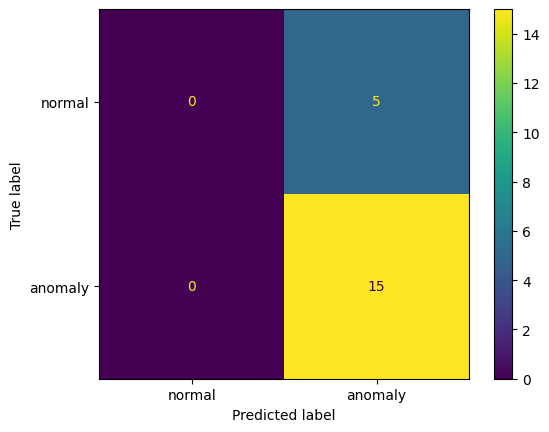

In [32]:
### Evaluation metrics

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, average_precision_score, ConfusionMatrixDisplay


# Calculate precision
precision = precision_score(y_true_all, y_pred_all)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_true_all, y_pred_all)
print(f'Recall: {recall:.4f}')

# # Calculate average precision
# average_precision = average_precision_score(y_true_all, y_pred_all)
# print(f'Average Precision: {average_precision:.4f}')

# Calculate F1 score
f1 = f1_score(y_true_all, y_pred_all)
print(f"F1 Score: {f1:.4f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)
print("Confusion Matrix:")
print(conf_matrix)
if len(conf_matrix) == 1:
    conf_matrix = np.array([[0, 0], [0, conf_matrix[0][0]]])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['normal', 'anomaly'])
disp.plot()

## Save Detections

In [20]:
######## save detections for the dashboard to plot #############
import traceback

for test_data, detections, test_label in all_detections:
    # print(test_data, test_label)
    # print(test_label.replace('labels', 'detections'))
    detection_path = test_label.replace('labels', f'ei_detections')
    detection_path = detection_path.replace('ei_detections.json', f'ei_detections_{DIFF_VAL}.json')
    # tp_detection_path = detection_path.replace('ei_detections.json', f'tp_ei_detections_{DIFF_VAL}.json')
    # fp_detection_path = detection_path.replace('ei_detections.json', f'fp_ei_detections_{DIFF_VAL}.json')
    # print(detections)
    # print(detection_path)

    detection_dir = os.path.dirname(detection_path)
    # print(detection_dir)
    if not os.path.exists(detection_dir):
        os.makedirs(detection_dir)
        print(f'Created Directory: {detection_dir}')

    try:
        with open(detection_path, 'w') as f:
            json.dump(detections, f)
            print(f'Saved detections in {detection_path}')

            
    except Exception as e:
        traceback.print_exception(e)
        print('Error in saving detections')
        continue

for test_data, detections, test_label in all_tp:
    # print(test_data, test_label)
    # print(test_label.replace('labels', 'detections'))
    detection_path = test_label.replace('labels', 'ei_detections')
    tp_detection_path = detection_path.replace('ei_detections.json', f'tp_ei_detections_{DIFF_VAL}.json')
    # fp_detection_path = detection_path.replace('ei_detections.json', 'fp_ei_detections.json')
    # print(detections)

    detection_dir = os.path.dirname(detection_path)
    # print(detection_dir)
    if not os.path.exists(detection_dir):
        os.makedirs(detection_dir)
        print(f'Created Directory: {detection_dir}')

    try:

        with open(tp_detection_path, 'w') as f:
            json.dump(detections, f)
            print(f'Saved detections in {tp_detection_path}')
            
    except Exception as e:
        traceback.print_exception(e)
        print('Error in saving detections')
        continue

for test_data, detections, test_label in all_fp:
    # print(test_data, test_label)
    # print(test_label.replace('labels', 'detections'))
    detection_path = test_label.replace('labels', 'ei_detections')
    # tp_detection_path = detection_path.replace('ei_detections.json', 'tp_ei_detections.json')
    fp_detection_path = detection_path.replace('ei_detections.json', f'fp_ei_detections_{DIFF_VAL}.json')
    # print(detections)

    detection_dir = os.path.dirname(detection_path)
    # print(detection_dir)
    if not os.path.exists(detection_dir):
        os.makedirs(detection_dir)
        print(f'Created Directory: {detection_dir}')

    try:

        with open(fp_detection_path, 'w') as f:
            json.dump(detections, f)
            print(f'Saved detections in {fp_detection_path}')
            
    except Exception as e:
        traceback.print_exception(e)
        print('Error in saving detections')
        continue

Saved detections in ../trace_data/mamba2/single_thread/version_3/faulty_data/ei_detections/trace_trial2_ei_detections_5.json
Saved detections in ../trace_data/mamba2/single_thread/version_3/faulty_data/ei_detections/trace_trial3_ei_detections_5.json
Saved detections in ../trace_data/mamba2/single_thread/version_3/faulty_data/ei_detections/trace_trial4_ei_detections_5.json
Saved detections in ../trace_data/mamba2/single_thread/version_3/faulty_data/ei_detections/trace_trial2_tp_ei_detections_5.json
Saved detections in ../trace_data/mamba2/single_thread/version_3/faulty_data/ei_detections/trace_trial3_tp_ei_detections_5.json
Saved detections in ../trace_data/mamba2/single_thread/version_3/faulty_data/ei_detections/trace_trial4_tp_ei_detections_5.json
Saved detections in ../trace_data/mamba2/single_thread/version_3/faulty_data/ei_detections/trace_trial2_fp_ei_detections_5.json
Saved detections in ../trace_data/mamba2/single_thread/version_3/faulty_data/ei_detections/trace_trial3_fp_ei_det

In [21]:
# print('Total Detections:', len(all_detections[1][1]))
# print('Total Groups:', len(all_group_detections[1][1]))
# i=0
# for item in all_group_detections[1][1]:
#     for ind_item in item:
#         i+=1
# print('Detections in Groups:', i)
# print('Total Merged:', len(all_merged_detections[1][1]))

## Plot Detections

In [22]:
# ### plot gt and detections
# for test_data, detections, test_label in all_detections:
# # for test_data, detections, test_label in all_fp:
#     # print('test_data:', test_data)
#     # print('detections:', detections)
#     # print(test_label)

#     ### prepare trace to plot
#     col_data = preprocess_traces([test_data])
#     all_df = get_dataframe(col_data) 
#     # print(all_df[0])

#     ### prepare detections to plot
#     timestamps = col_data[0][1]
#     print('timestamps:', timestamps)
#     plot_val = []
#     plot_x_ticks = []
#     plot_class = []
#     for det in detections:
#         # print(det)
#         det_ts1, det_ts2 = det[1]
#         # print(det_ts1, det_ts2)

#         det_ind1_pre = [ abs(t-det_ts1) for t in timestamps]
#         det_ind1 = det_ind1_pre.index(min(det_ind1_pre))

#         det_ind2_pre = [ abs(t-det_ts2) for t in timestamps]
#         det_ind2 = det_ind2_pre.index(min(det_ind2_pre))
#         # print(det_ind1, det_ind2)
#         # print(timestamps[det_ind1], timestamps[det_ind2])

#         plot_val += [(det_ind1, det_ind2)]
#         plot_x_ticks += [(timestamps[det_ind1], timestamps[det_ind2])]
#         plot_class += [0]

#     plot_detections = [plot_val, plot_x_ticks, plot_class]

#     ### get ground truths
#     gt_plot = prepare_gt(test_label)

#     ### plot
#     for df in all_df:
#         # print(df.columns)
#         plot_fig = plot_single_trace(df, 
#                           var_list, 
#                           with_time=False, 
#                           is_xticks=True, 
#                           detections=plot_detections, 
#                           dt_classlist=['detection'],
#                           ground_truths=gt_plot,
#                           gt_classlist=['gt_communication', 'gt_sensor', 'gt_bitflip'],
#                           )
#         plot_fig.show()

#     # break

In [23]:
# ##### plot merged detections
# ### plot gt and detections
# # for test_data, detections, test_label in all_detections:
# # for test_data, detections, test_label in all_merged_detections: #### all merged detections
# for test_data, detections, test_label in all_fp:
#     # print('test_data:', test_data)
#     # print('detections:', detections)
#     # print(test_label)

#     ### prepare trace to plot
#     col_data = preprocess_traces([test_data])
#     all_df = get_dataframe(col_data) 
#     # print(all_df[0])

#     ### prepare detections to plot
#     timestamps = col_data[0][1]
#     print('timestamps:', timestamps)
#     plot_val = []
#     plot_x_ticks = []
#     plot_class = []
#     for det in detections:
#         # print(det)
#         det_ts1, det_ts2 = det[1]
#         # print(det_ts1, det_ts2)

#         det_ind1_pre = [ abs(t-det_ts1) for t in timestamps]
#         det_ind1 = det_ind1_pre.index(min(det_ind1_pre))

#         det_ind2_pre = [ abs(t-det_ts2) for t in timestamps]
#         det_ind2 = det_ind2_pre.index(min(det_ind2_pre))
#         # print(det_ind1, det_ind2)
#         # print(timestamps[det_ind1], timestamps[det_ind2])

#         plot_val += [(det_ind1, det_ind2)]
#         plot_x_ticks += [(timestamps[det_ind1], timestamps[det_ind2])]
#         plot_class += [0]

#     plot_detections = [plot_val, plot_x_ticks, plot_class]

#     ### get ground truths
#     gt_plot = prepare_gt(test_label)

#     ### plot
#     for df in all_df:
#         # print(df.columns)
#         plot_fig = plot_single_trace(df, 
#                           var_list, 
#                           with_time=False, 
#                           is_xticks=True, 
#                           detections=plot_detections, 
#                           dt_classlist=['detection'],
#                           ground_truths=gt_plot,
#                           gt_classlist=['gt_communication', 'gt_sensor', 'gt_bitflip'],
#                           )
#         plot_fig.show()

#     # break

In [24]:
1890

1890

Observations
---
- since multiple variables are affected due to single anomaly, multiple detections are generated for each anomaly.
- This leads to multiple FP.
- To avoid this, we implement deduplication which groups the detections that are close to each other bsed on timestamp
- However, in this process along with decrease in FP, we have more False Negatives i.e. some anomalies are not detected. 

TODO:
- change deduplication stratergy, if possible